###Imports

In [ ]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import transforms
import os
import numpy as np
import random
from tqdm import tqdm
from PIL import Image
from google.colab import drive
from torchvision.transforms import functional as F
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.optim as optim
!pip install optuna
import optuna
import optuna.visualization as vis
import time
import sys

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

if not os.path.exists('/content/kitti_dataset'):
    drive.mount('/content/drive')
    !unzip -q "/content/drive/My Drive/Colab Notebooks/DeepLabv3_Playground/data_semantics.zip" -d "/content/kitti_dataset"
else:
    print('Dataset already extracted.')

# Set the seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.1 MB/s eta 0:00:00
Mounted at /content/drive


###Define Kitti Dataset Class

In [ ]:
class KITTIDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if random.random() > 0.5:
          image = F.hflip(image)
          mask = F.hflip(mask)

        if self.transform:
            image, mask = self.transform(image, mask)  # Adjusted to pass both image and mask

        return image, mask

###Normalization Calculations
We calculate the mean and std of our dataset to normalize

In [ ]:
def compute_mean_std(image_dir):
    to_tensor = ToTensor()
    images = os.listdir(image_dir)
    n_channels = 3  # For RGB images

    sum_channels = np.zeros(n_channels)
    sum_squared_channels = np.zeros(n_channels)
    n_pixels = 0

    for image_name in images:
        img_path = os.path.join(image_dir, image_name)
        image = Image.open(img_path).convert("RGB")
        image = to_tensor(image)

        sum_channels += image.view(n_channels, -1).sum(axis=1).numpy()
        sum_squared_channels += (image.view(n_channels, -1) ** 2).sum(axis=1).numpy()
        n_pixels += image.numel() / n_channels

    mean = sum_channels / n_pixels
    std = np.sqrt((sum_squared_channels / n_pixels) - (mean ** 2))

    return mean, std

image_dir = "/content/kitti_dataset/data_semantics/training/image_2"  # Adjust path as needed
mean, std = compute_mean_std(image_dir)
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: [0.37910411 0.39846688 0.38367168]
Std: [0.31077275 0.31944112 0.3287303 ]


###Define and Initialize Model

Determine number of output classes

In [ ]:
def find_unique_classes(mask_dir):
    unique_classes = set()
    for mask_file in tqdm(os.listdir(mask_dir)):
        mask_path = os.path.join(mask_dir, mask_file)
        mask = np.array(Image.open(mask_path))
        unique_classes.update(np.unique(mask))
    return unique_classes

# Set the directory where your masks are located
mask_dir = "/content/kitti_dataset/data_semantics/training/semantic"
unique_classes = find_unique_classes(mask_dir)
print(f"Unique classes in the dataset: {unique_classes}")
print(f"Total number of unique classes: {len(unique_classes)}")

100%|██████████| 200/200 [00:02<00:00, 75.95it/s]

Unique classes in the dataset: {0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}
Total number of unique classes: 31


Initialize model using the above output classes

In [ ]:
def custom_DeepLabv3(out_channels):
    model = deeplabv3_resnet50(pretrained=False)

    model.classifier[4] = torch.nn.Conv2d(256, out_channels, kernel_size=(1, 1), stride=(1, 1))

    if model.aux_classifier is not None:
        model.aux_classifier[4] = torch.nn.Conv2d(256, out_channels, kernel_size=(1, 1), stride=(1, 1))

    return model

model = custom_DeepLabv3(out_channels=34)
model.eval()

# Print out the output layer
print(model.classifier[4])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 122MB/s]


Conv2d(256, 34, kernel_size=(1, 1), stride=(1, 1))


###Define transformation function

In [ ]:
def transform(image, mask):
    # Resize images and masks to a fixed size
    image = F.resize(image, (512, 512))
    mask = F.resize(mask, (512, 512), interpolation=Image.NEAREST)

    # Convert to tensor
    image = F.to_tensor(image)
    mask = torch.from_numpy(np.array(mask)).long()  # CrossEntropyLoss expects long type tensor

    # Normalize the image with dataset mean and std
    normalize = transforms.Normalize(mean=mean, std=std)
    image = normalize(image)

    return image, mask

###Initialize the dataset

In [ ]:
# Initialize the dataset with transformations
final_dataset = KITTIDataset(
    image_dir="/content/kitti_dataset/data_semantics/training/image_2",
    mask_dir="/content/kitti_dataset/data_semantics/training/semantic",
    transform=transform
)

# Seed for reproducibility
torch.manual_seed(42)

print(len(final_dataset))

200


###Prepare model for training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cpu


###Training loop using optuna for hyperparameter tuning

In [ ]:
def objective(trial):
    # Hyperparameters to be optimized
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [2, 4, 8])
    epochs = 30
    weight_decay = 1e-5

    # Train-validation split (for example, 80-20 split)
    train_size = int(0.8 * len(final_dataset))
    val_size = len(final_dataset) - train_size
    train_dataset, val_dataset = random_split(final_dataset, [train_size, val_size])

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model initialization
    model = custom_DeepLabv3(out_channels=34)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Training loop
    for epoch in tqdm(range(epochs)):
        model.train()
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

    # Validation loop
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for images, masks in validation_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            validation_loss += loss.item()
    validation_loss /= len(val_dataset)  # Average loss for validation
    return validation_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30, callbacks=[lambda study, trial: tqdm.write(f'Trial {trial.number} finished with value: {trial.value} and parameters: {trial.params}. Best is trial {study.best_trial.number} with value: {study.best_trial.value}.')])

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2024-04-08 00:28:10,177] A new study created in memory with name: no-name-7cb6a482-1b50-47d7-b93d-23e5b6904e47
<ipython-input-21-be97c92e6904>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
100%|██████████| 30/30 [03:01<00:00,  6.06s/it]
[I 2024-04-08 00:31:13,763] Trial 0 finished with value: 0.17942946143448352 and parameters: {'lr': 0.0006641756045851356, 'batch_size': 2}. Best is trial 0 with value: 0.17942946143448352.


Trial 0 finished with value: 0.17942946143448352 and parameters: {'lr': 0.0006641756045851356, 'batch_size': 2}. Best is trial 0 with value: 0.17942946143448352.


100%|██████████| 30/30 [02:06<00:00,  4.22s/it]
[I 2024-04-08 00:33:22,065] Trial 1 finished with value: 0.056252818554639816 and parameters: {'lr': 0.00028342059752892873, 'batch_size': 8}. Best is trial 1 with value: 0.056252818554639816.


Trial 1 finished with value: 0.056252818554639816 and parameters: {'lr': 0.00028342059752892873, 'batch_size': 8}. Best is trial 1 with value: 0.056252818554639816.


100%|██████████| 30/30 [02:23<00:00,  4.79s/it]
[I 2024-04-08 00:35:47,591] Trial 2 finished with value: 0.24932177662849425 and parameters: {'lr': 0.0017627791087727652, 'batch_size': 4}. Best is trial 1 with value: 0.056252818554639816.


Trial 2 finished with value: 0.24932177662849425 and parameters: {'lr': 0.0017627791087727652, 'batch_size': 4}. Best is trial 1 with value: 0.056252818554639816.


100%|██████████| 30/30 [02:05<00:00,  4.18s/it]
[I 2024-04-08 00:37:54,852] Trial 3 finished with value: 0.04870320782065392 and parameters: {'lr': 0.0015544786584616764, 'batch_size': 8}. Best is trial 3 with value: 0.04870320782065392.


Trial 3 finished with value: 0.04870320782065392 and parameters: {'lr': 0.0015544786584616764, 'batch_size': 8}. Best is trial 3 with value: 0.04870320782065392.


100%|██████████| 30/30 [02:23<00:00,  4.79s/it]
[I 2024-04-08 00:40:20,355] Trial 4 finished with value: 0.09457475766539573 and parameters: {'lr': 0.00045287087704464515, 'batch_size': 4}. Best is trial 3 with value: 0.04870320782065392.


Trial 4 finished with value: 0.09457475766539573 and parameters: {'lr': 0.00045287087704464515, 'batch_size': 4}. Best is trial 3 with value: 0.04870320782065392.


100%|██████████| 30/30 [03:00<00:00,  6.00s/it]
[I 2024-04-08 00:43:22,176] Trial 5 finished with value: 0.40698200166225434 and parameters: {'lr': 0.004878582175887212, 'batch_size': 2}. Best is trial 3 with value: 0.04870320782065392.


Trial 5 finished with value: 0.40698200166225434 and parameters: {'lr': 0.004878582175887212, 'batch_size': 2}. Best is trial 3 with value: 0.04870320782065392.


100%|██████████| 30/30 [03:00<00:00,  6.01s/it]
[I 2024-04-08 00:46:24,358] Trial 6 finished with value: 0.23653499707579612 and parameters: {'lr': 0.0014901431658133932, 'batch_size': 2}. Best is trial 3 with value: 0.04870320782065392.


Trial 6 finished with value: 0.23653499707579612 and parameters: {'lr': 0.0014901431658133932, 'batch_size': 2}. Best is trial 3 with value: 0.04870320782065392.


100%|██████████| 30/30 [02:24<00:00,  4.82s/it]
[I 2024-04-08 00:48:50,583] Trial 7 finished with value: 0.07497555464506149 and parameters: {'lr': 0.0002399085636891818, 'batch_size': 4}. Best is trial 3 with value: 0.04870320782065392.


Trial 7 finished with value: 0.07497555464506149 and parameters: {'lr': 0.0002399085636891818, 'batch_size': 4}. Best is trial 3 with value: 0.04870320782065392.


100%|██████████| 30/30 [03:04<00:00,  6.16s/it]
[I 2024-04-08 00:51:57,243] Trial 8 finished with value: 0.37172461934387685 and parameters: {'lr': 0.0008251905139289267, 'batch_size': 2}. Best is trial 3 with value: 0.04870320782065392.


Trial 8 finished with value: 0.37172461934387685 and parameters: {'lr': 0.0008251905139289267, 'batch_size': 2}. Best is trial 3 with value: 0.04870320782065392.


100%|██████████| 30/30 [03:01<00:00,  6.05s/it]
[I 2024-04-08 00:55:00,556] Trial 9 finished with value: 0.3238188993185759 and parameters: {'lr': 0.0007072571209725071, 'batch_size': 2}. Best is trial 3 with value: 0.04870320782065392.


Trial 9 finished with value: 0.3238188993185759 and parameters: {'lr': 0.0007072571209725071, 'batch_size': 2}. Best is trial 3 with value: 0.04870320782065392.


100%|██████████| 30/30 [02:05<00:00,  4.19s/it]
[I 2024-04-08 00:57:08,016] Trial 10 finished with value: 0.0671110101044178 and parameters: {'lr': 0.00010507759843736119, 'batch_size': 8}. Best is trial 3 with value: 0.04870320782065392.


Trial 10 finished with value: 0.0671110101044178 and parameters: {'lr': 0.00010507759843736119, 'batch_size': 8}. Best is trial 3 with value: 0.04870320782065392.


100%|██████████| 30/30 [02:05<00:00,  4.18s/it]
[I 2024-04-08 00:59:15,078] Trial 11 finished with value: 0.08645109683275223 and parameters: {'lr': 0.003909264686464607, 'batch_size': 8}. Best is trial 3 with value: 0.04870320782065392.


Trial 11 finished with value: 0.08645109683275223 and parameters: {'lr': 0.003909264686464607, 'batch_size': 8}. Best is trial 3 with value: 0.04870320782065392.


100%|██████████| 30/30 [02:05<00:00,  4.19s/it]
[I 2024-04-08 01:01:22,477] Trial 12 finished with value: 0.04192792661488056 and parameters: {'lr': 0.000218912219780465, 'batch_size': 8}. Best is trial 12 with value: 0.04192792661488056.


Trial 12 finished with value: 0.04192792661488056 and parameters: {'lr': 0.000218912219780465, 'batch_size': 8}. Best is trial 12 with value: 0.04192792661488056.


100%|██████████| 30/30 [02:06<00:00,  4.22s/it]
[I 2024-04-08 01:03:30,858] Trial 13 finished with value: 0.16978774815797806 and parameters: {'lr': 0.009203283936529237, 'batch_size': 8}. Best is trial 12 with value: 0.04192792661488056.


Trial 13 finished with value: 0.16978774815797806 and parameters: {'lr': 0.009203283936529237, 'batch_size': 8}. Best is trial 12 with value: 0.04192792661488056.


100%|██████████| 30/30 [02:09<00:00,  4.31s/it]
[I 2024-04-08 01:05:41,759] Trial 14 finished with value: 0.039649884775280954 and parameters: {'lr': 0.00010310410870761384, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


Trial 14 finished with value: 0.039649884775280954 and parameters: {'lr': 0.00010310410870761384, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


100%|██████████| 30/30 [02:07<00:00,  4.24s/it]
[I 2024-04-08 01:07:50,600] Trial 15 finished with value: 0.06712351590394974 and parameters: {'lr': 0.00011375443091171352, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


Trial 15 finished with value: 0.06712351590394974 and parameters: {'lr': 0.00011375443091171352, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


100%|██████████| 30/30 [02:07<00:00,  4.24s/it]
[I 2024-04-08 01:09:59,489] Trial 16 finished with value: 0.04418048709630966 and parameters: {'lr': 0.00019725368454138068, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


Trial 16 finished with value: 0.04418048709630966 and parameters: {'lr': 0.00019725368454138068, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


100%|██████████| 30/30 [02:05<00:00,  4.19s/it]
[I 2024-04-08 01:12:06,856] Trial 17 finished with value: 0.04503663182258606 and parameters: {'lr': 0.00016296509496687767, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


Trial 17 finished with value: 0.04503663182258606 and parameters: {'lr': 0.00016296509496687767, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


100%|██████████| 30/30 [02:06<00:00,  4.22s/it]
[I 2024-04-08 01:14:15,344] Trial 18 finished with value: 0.04380326457321644 and parameters: {'lr': 0.0004299599052949684, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


Trial 18 finished with value: 0.04380326457321644 and parameters: {'lr': 0.0004299599052949684, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


100%|██████████| 30/30 [02:08<00:00,  4.27s/it]
[I 2024-04-08 01:16:25,211] Trial 19 finished with value: 0.06900704130530358 and parameters: {'lr': 0.00029576129818760266, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


Trial 19 finished with value: 0.06900704130530358 and parameters: {'lr': 0.00029576129818760266, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


100%|██████████| 30/30 [02:25<00:00,  4.84s/it]
[I 2024-04-08 01:18:52,161] Trial 20 finished with value: 0.13163772895932196 and parameters: {'lr': 0.00016998599896028314, 'batch_size': 4}. Best is trial 14 with value: 0.039649884775280954.


Trial 20 finished with value: 0.13163772895932196 and parameters: {'lr': 0.00016998599896028314, 'batch_size': 4}. Best is trial 14 with value: 0.039649884775280954.


100%|██████████| 30/30 [02:07<00:00,  4.24s/it]
[I 2024-04-08 01:21:00,996] Trial 21 finished with value: 0.04487627223134041 and parameters: {'lr': 0.00044168665101095657, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


Trial 21 finished with value: 0.04487627223134041 and parameters: {'lr': 0.00044168665101095657, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


100%|██████████| 30/30 [02:06<00:00,  4.23s/it]
[I 2024-04-08 01:23:09,624] Trial 22 finished with value: 0.045047274231910704 and parameters: {'lr': 0.0003844365656394949, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


Trial 22 finished with value: 0.045047274231910704 and parameters: {'lr': 0.0003844365656394949, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


100%|██████████| 30/30 [02:05<00:00,  4.18s/it]
[I 2024-04-08 01:25:16,810] Trial 23 finished with value: 0.06863874718546867 and parameters: {'lr': 0.0001319148237708211, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


Trial 23 finished with value: 0.06863874718546867 and parameters: {'lr': 0.0001319148237708211, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


100%|██████████| 30/30 [02:06<00:00,  4.23s/it]
[I 2024-04-08 01:27:25,359] Trial 24 finished with value: 0.05539180561900139 and parameters: {'lr': 0.00021550994686169472, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


Trial 24 finished with value: 0.05539180561900139 and parameters: {'lr': 0.00021550994686169472, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


100%|██████████| 30/30 [02:09<00:00,  4.30s/it]
[I 2024-04-08 01:29:36,112] Trial 25 finished with value: 0.046769771724939346 and parameters: {'lr': 0.00035279801844892444, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


Trial 25 finished with value: 0.046769771724939346 and parameters: {'lr': 0.00035279801844892444, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


100%|██████████| 30/30 [02:05<00:00,  4.17s/it]
[I 2024-04-08 01:31:43,074] Trial 26 finished with value: 0.04036869369447231 and parameters: {'lr': 0.0005459129472821599, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


Trial 26 finished with value: 0.04036869369447231 and parameters: {'lr': 0.0005459129472821599, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


100%|██████████| 30/30 [02:04<00:00,  4.16s/it]
[I 2024-04-08 01:33:49,594] Trial 27 finished with value: 0.042097863554954526 and parameters: {'lr': 0.0001447506319084655, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


Trial 27 finished with value: 0.042097863554954526 and parameters: {'lr': 0.0001447506319084655, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


100%|██████████| 30/30 [02:05<00:00,  4.19s/it]
[I 2024-04-08 01:35:56,986] Trial 28 finished with value: 0.047283869981765744 and parameters: {'lr': 0.001092446301848279, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


Trial 28 finished with value: 0.047283869981765744 and parameters: {'lr': 0.001092446301848279, 'batch_size': 8}. Best is trial 14 with value: 0.039649884775280954.


100%|██████████| 30/30 [02:24<00:00,  4.81s/it]
[I 2024-04-08 01:38:22,923] Trial 29 finished with value: 0.08796979859471321 and parameters: {'lr': 0.0006216955368171782, 'batch_size': 4}. Best is trial 14 with value: 0.039649884775280954.


Trial 29 finished with value: 0.08796979859471321 and parameters: {'lr': 0.0006216955368171782, 'batch_size': 4}. Best is trial 14 with value: 0.039649884775280954.
Best trial:
  Value: 0.039649884775280954
  Params: 
    lr: 0.00010310410870761384
    batch_size: 8


hardcoded execution time for hyperparameter tuning: 01:38:22

Visualize the results of the hyperparameter tuning

In [ ]:
# Visualize the optimization history
vis.plot_optimization_history(study)

In [ ]:
# Visualize hyperparameter relationships
vis.plot_parallel_coordinate(study)

In [ ]:
# Visualize hyperparameter importance
vis.plot_param_importances(study)

###Final training regiment using optimized hyperparameters

In [ ]:
# Assuming the setup of your model, dataset, and criterion is defined similarly
# Initialize your model
model = custom_DeepLabv3(out_channels=34).to(device)

# Hyperparameters from best trial
lr = 0.00010310410870761384
batch_size = 8
epochs = 30
weight_decay = 1e-5

# Prepare DataLoader
train_size = int(0.8 * len(final_dataset))
val_size = len(final_dataset) - train_size
train_dataset, val_dataset = random_split(final_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Setup the optimizer
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
for epoch in range(epochs):
    model.train()
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for images, masks in validation_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            validation_loss += loss.item()
    if epoch % 5 == 0:
      print(f"Validation Loss after Epoch {epoch+1}: {validation_loss / len(val_dataset)}")

Epoch 1/30: 100%|██████████| 20/20 [00:04<00:00,  4.69it/s]


Validation Loss after Epoch 1: 0.14643219709396363


Epoch 6/30: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Validation Loss after Epoch 6: 0.07761174887418747


Epoch 11/30: 100%|██████████| 20/20 [00:04<00:00,  4.50it/s]


Validation Loss after Epoch 11: 0.05569066628813744


Epoch 16/30: 100%|██████████| 20/20 [00:04<00:00,  4.51it/s]


Validation Loss after Epoch 16: 0.051014824956655505


Epoch 21/30: 100%|██████████| 20/20 [00:04<00:00,  4.55it/s]


Validation Loss after Epoch 21: 0.04647349715232849


Epoch 26/30: 100%|██████████| 20/20 [00:04<00:00,  4.59it/s]


Validation Loss after Epoch 26: 0.04589415341615677


Epoch 30/30: 100%|██████████| 20/20 [00:04<00:00,  4.63it/s]


###Save model

In [ ]:
torch.save(model.state_dict(), 'deeplabv3model.pth')

###Visualize some output

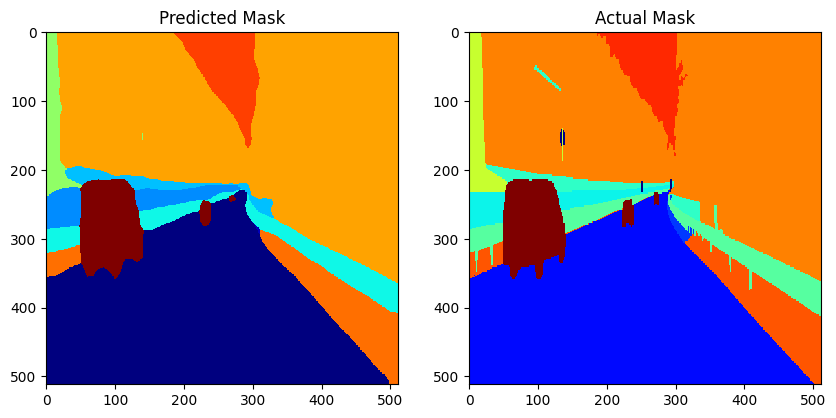

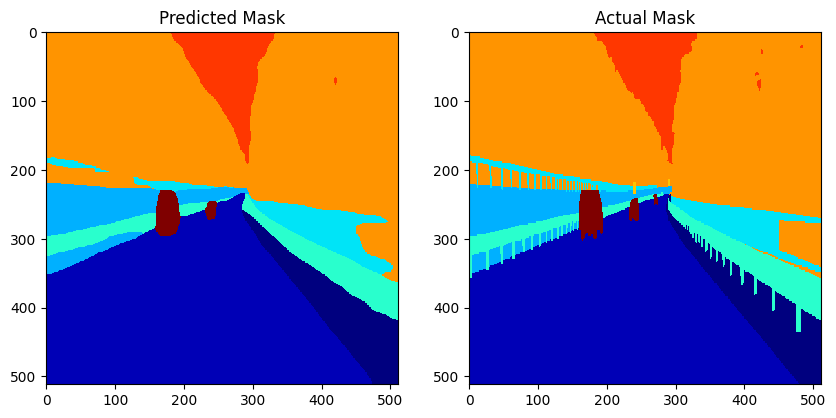

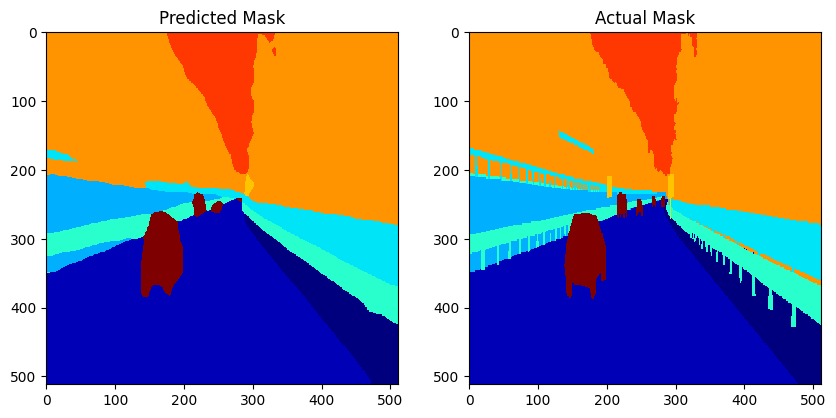

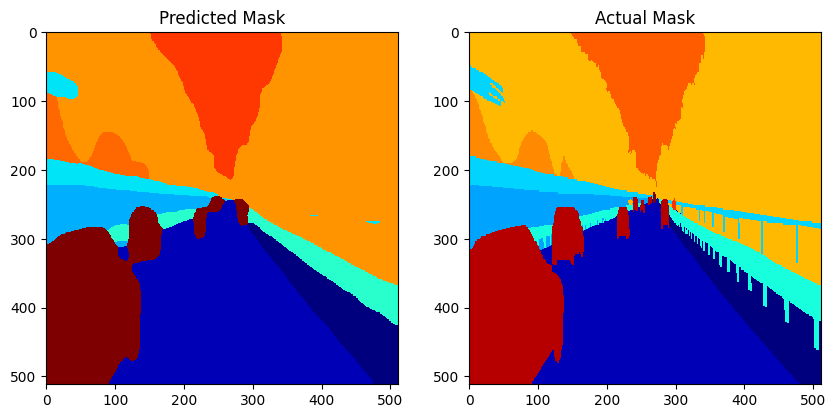

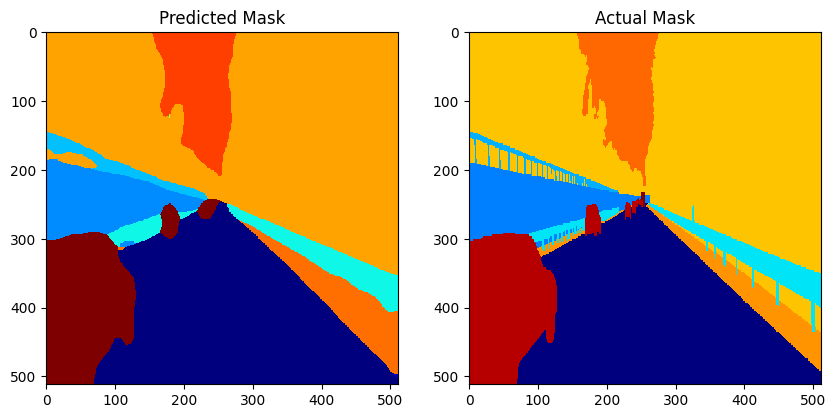

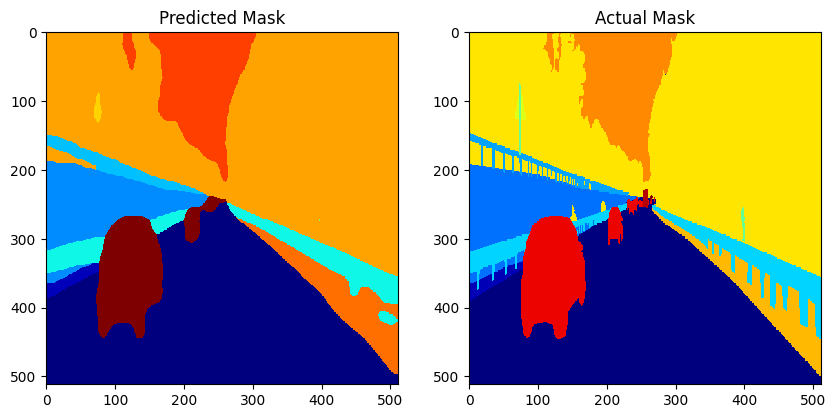

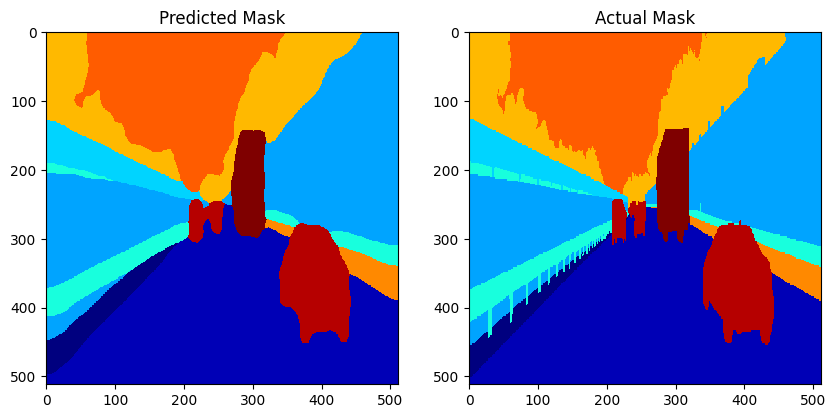

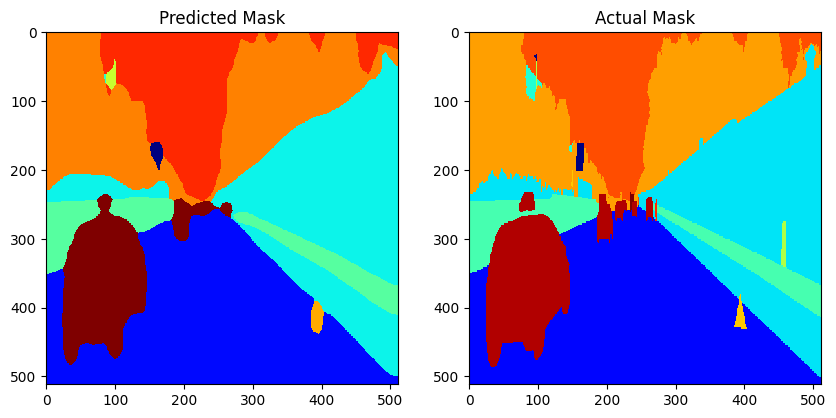

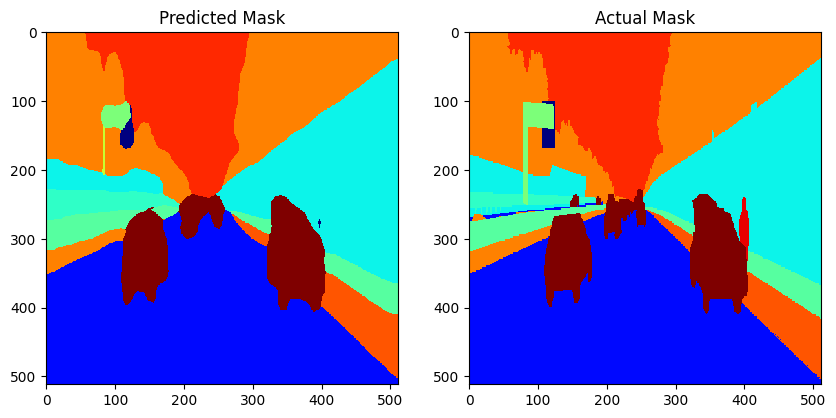

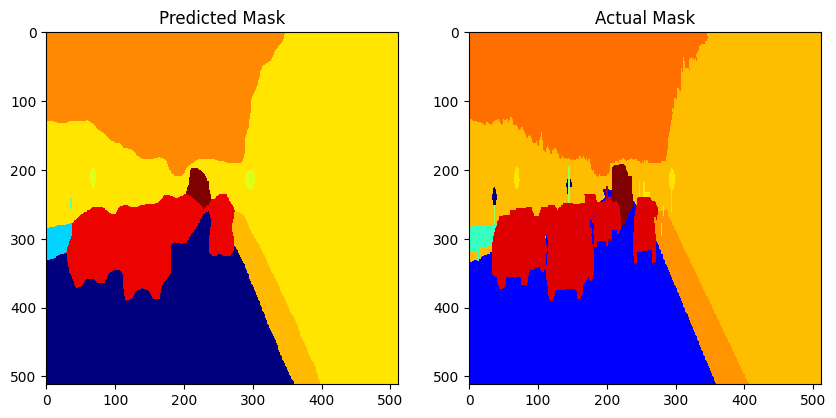

In [ ]:
# Ensure your model is in evaluation mode
model.eval()

# Specify the directories
image_dir = "/content/kitti_dataset/data_semantics/training/image_2"
mask_dir = "/content/kitti_dataset/data_semantics/training/semantic"

# List the first 10 images and masks
images_list = sorted(os.listdir(image_dir))[190:200]

# Visualization loop
with torch.no_grad():
    for image_name in images_list:
        img_path = os.path.join(image_dir, image_name)
        mask_path = os.path.join(mask_dir, image_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image, mask = transform(image, mask)

        image = image.unsqueeze(0).to(device)

        outputs = model(image)['out']

        predicted_mask = outputs.argmax(dim=1).cpu().numpy()
        actual_mask = mask.cpu().numpy()

        # Plotting
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(predicted_mask[0], cmap='jet', interpolation='nearest')
        axes[0].set_title('Predicted Mask')
        axes[1].imshow(actual_mask, cmap='jet', interpolation='nearest')
        axes[1].set_title('Actual Mask')
        plt.show()


###Performance Metrics for Segmentation

In [ ]:
#  Measures the inference time (time taken for the model to make predictions) using the validation dataset.
def measure_performance(model, dataloader, device):
  model.eval()
  start_time = time.time()
  with torch.no_grad():
    for images, masks in dataloader:
      images, masks = images.to(device), masks.to(device)
      outputs = model(images)['out']
  end_time = time.time()
  inference_time = end_time - start_time
  return inference_time

def measure_resource_load(model):
  model_size = sys.getsizeof(model.state_dict()) / (1024 * 1024)
  return model_size

# Measures the accuracy of the model on the validation dataset.
def measure_accuracy(model, dataloader, device):
  model.eval()
  correct_predictions = 0
  total_predictions = 0
  with torch.no_grad():
    for images, masks in dataloader:
      images, masks = images.to(device), masks.to(device)
      outputs = model(images)['out']
      predicted_masks = outputs.argmax(dim=1)
      correct_predictions += (predicted_masks == masks).sum().item()
      total_predictions += images.size(0) * images.size(2) * images.size(3)  # Number of pixels
  accuracy = correct_predictions / total_predictions
  return accuracy

In [ ]:
inference_time = measure_performance(model, validation_loader, device)
print(f"Inference Time: {inference_time:.2f} seconds")

model_size = measure_resource_load(model)
print(f"Model Size: {model_size:.2f} MB")

model_accuracy = measure_accuracy(model, validation_loader, device)
print(f"Model Accuracy: {model_accuracy:.2f}")

###Performance Metrics for Classification

Setup for getting metrics

In [ ]:
model = custom_DeepLabv3(out_channels=34)
model.load_state_dict(torch.load('deeplabv3model.pth', map_location=torch.device('cpu')))
model.eval()
model.to(device)

In [ ]:
predictions = []
targets = []
train_size = int(0.8 * len(final_dataset))
val_size = len(final_dataset) - train_size
train_dataset, val_dataset = random_split(final_dataset, [train_size, val_size])
validation_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

with torch.no_grad():
  for images, masks in validation_loader:
    images, masks = images.to(device), masks.to(device)
    outputs = model(images)['out']
    predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
    targets.extend(masks.cpu().numpy())

In [ ]:
labels = [
    {'name': 'unlabeled', 'id': 0, 'category': 'void', 'catId': 0},
    {'name': 'ego vehicle', 'id': 1, 'category': 'void', 'catId': 0},
    {'name': 'rectification border', 'id': 2, 'category': 'void', 'catId': 0},
    {'name': 'out of roi', 'id': 3, 'category': 'void', 'catId': 0},
    {'name': 'static', 'id': 4, 'category': 'void', 'catId': 0},
    {'name': 'dynamic', 'id': 5, 'category': 'void', 'catId': 0},
    {'name': 'ground', 'id': 6, 'category': 'void', 'catId': 0},
    {'name': 'road', 'id': 7, 'category': 'flat', 'catId': 1},
    {'name': 'sidewalk', 'id': 8, 'category': 'flat', 'catId': 1},
    {'name': 'parking', 'id': 9, 'category': 'flat', 'catId': 1},
    {'name': 'rail track', 'id': 10, 'category': 'flat', 'catId': 1},
    {'name': 'building', 'id': 11, 'category': 'construction', 'catId': 2},
    {'name': 'wall', 'id': 12, 'category': 'construction', 'catId': 2},
    {'name': 'fence', 'id': 13, 'category': 'construction', 'catId': 2},
    {'name': 'guard rail', 'id': 14, 'category': 'construction', 'catId': 2},
    {'name': 'bridge', 'id': 15, 'category': 'construction', 'catId': 2},
    {'name': 'tunnel', 'id': 16, 'category': 'construction', 'catId': 2},
    {'name': 'pole', 'id': 17, 'category': 'object', 'catId': 3},
    {'name': 'polegroup', 'id': 18, 'category': 'object', 'catId': 3},
    {'name': 'traffic light', 'id': 19, 'category': 'object', 'catId': 3},
    {'name': 'traffic sign', 'id': 20, 'category': 'object', 'catId': 3},
    {'name': 'vegetation', 'id': 21, 'category': 'nature', 'catId': 4},
    {'name': 'terrain', 'id': 22, 'category': 'nature', 'catId': 4},
    {'name': 'sky', 'id': 23, 'category': 'sky', 'catId': 5},
    {'name': 'person', 'id': 24, 'category': 'human', 'catId': 6},
    {'name': 'rider', 'id': 25, 'category': 'human', 'catId': 6},
    {'name': 'car', 'id': 26, 'category': 'vehicle', 'catId': 7},
    {'name': 'truck', 'id': 27, 'category': 'vehicle', 'catId': 7},
    {'name': 'bus', 'id': 28, 'category': 'vehicle', 'catId': 7},
    {'name': 'caravan', 'id': 29, 'category': 'vehicle', 'catId': 7},
    {'name': 'trailer', 'id': 30, 'category': 'vehicle', 'catId': 7},
    {'name': 'train', 'id': 31, 'category': 'vehicle', 'catId': 7},
    {'name': 'motorcycle', 'id': 32, 'category': 'vehicle', 'catId': 7},
    {'name': 'bicycle', 'id': 33, 'category': 'vehicle', 'catId': 7},
]
class_names = [label['name'] for label in labels]

Get metrics across all classes

In [ ]:
# Calculate Metrics IoU, mIoU, Precision, Recall, and FI-Score
from sklearn.metrics import confusion_matrix

def calculate_metrics(predictions, targets, num_classes):
    num_classes = len(labels)
    class_names = [label['name'] for label in labels]
    # Flatten predictions and targets
    predictions_flat = np.array(predictions).flatten()
    targets_flat = np.array(targets).flatten()

    # Initialize variables to store metrics
    intersection = np.zeros(num_classes)
    union = np.zeros(num_classes)
    true_positives = np.zeros(num_classes)
    false_positives = np.zeros(num_classes)
    false_negatives = np.zeros(num_classes)

    # Calculate metrics for each class
    for class_id in range(num_classes):
        class_predictions = (predictions_flat == class_id)
        class_targets = (targets_flat == class_id)

        intersection[class_id] = np.logical_and(class_predictions, class_targets).sum()
        union[class_id] = np.logical_or(class_predictions, class_targets).sum()
        true_positives[class_id] = intersection[class_id]
        false_positives[class_id] = np.logical_and(class_predictions, ~class_targets).sum()
        false_negatives[class_id] = np.logical_and(~class_predictions, class_targets).sum()

    # Exclude classes with NaN values from computation
    valid_classes = np.where(~np.isnan(union))[0]
    intersection = intersection[valid_classes]
    union = union[valid_classes]
    true_positives = true_positives[valid_classes]
    false_positives = false_positives[valid_classes]
    false_negatives = false_negatives[valid_classes]

    # Calculate IoU, Precision, Recall, and F1-Score
    iou = np.divide(intersection, union, out=np.zeros_like(intersection), where=union!=0)
    precision = np.divide(true_positives, (true_positives + false_positives), out=np.zeros_like(true_positives), where=(true_positives + false_positives)!=0)
    recall = np.divide(true_positives, (true_positives + false_negatives), out=np.zeros_like(true_positives), where=(true_positives + false_negatives)!=0)
    # handling of division by zero
    valid_precision_recall_mask = (precision + recall) > 0
    f1_score = np.zeros_like(precision)
    f1_score[valid_precision_recall_mask] = 2 * (precision[valid_precision_recall_mask] * recall[valid_precision_recall_mask]) / (precision[valid_precision_recall_mask] + recall[valid_precision_recall_mask])

    metrics_with_names = {}
    for i, name in enumerate(class_names):
        metrics_with_names[name] = {
            'IoU': iou[i],
            'Precision': precision[i],
            'Recall': recall[i],
            'F1-Score': f1_score[i]
        }

    # Calculate mIoU
    valid_iou = [metrics_with_names[name]['IoU'] for name in class_names]
    mIoU = np.mean(valid_iou)

    return mIoU, metrics_with_names

mIoU, metrics_with_names = calculate_metrics(predictions, targets, labels)

# Initialize sums of metrics
sum_precision = 0
sum_recall = 0
sum_f1_score = 0
count = 0

# Iterate over each class to sum up metrics
for class_name, metrics in metrics_with_names.items():
    sum_precision += metrics['Precision']
    sum_recall += metrics['Recall']
    sum_f1_score += metrics['F1-Score']
    count += 1

# Calculate averages
average_precision = sum_precision / count
average_recall = sum_recall / count
average_f1_score = sum_f1_score / count

# Print mIoU and Average Metrics
print(f"mIoU: {mIoU:.4f}")
print(f"Average Precision: {average_precision:.4f}")
print(f"Average Recall: {average_recall:.4f}")
print(f"Average F1-Score: {average_f1_score:.4f}")
for class_name, scores in metrics_with_names.items():
    print(f"Class: {class_name}, Scores: {scores}")



mIoU: 0.4922
Average Precision: 0.5753
Average Recall: 0.5426
Average F1-Score: 0.5561
Class: unlabeled, Scores: {'IoU': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0}
Class: ego vehicle, Scores: {'IoU': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0}
Class: rectification border, Scores: {'IoU': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0}
Class: out of roi, Scores: {'IoU': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0}
Class: static, Scores: {'IoU': 0.5722450081643674, 'Precision': 0.8230469797416623, 'Recall': 0.6525260966455547, 'F1-Score': 0.7279336301820754}
Class: dynamic, Scores: {'IoU': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0}
Class: ground, Scores: {'IoU': 0.6168673336724888, 'Precision': 0.8034899131203063, 'Recall': 0.7264678471575023, 'F1-Score': 0.7630401342469585}
Class: road, Scores: {'IoU': 0.9560762438424498, 'Precision': 0.9795340222517792, 'Recall': 0.9755639738406916, 'F1-Score': 0.977544967229259}
Class: sidewalk, Scor

Get metrics accross categories of classes

In [ ]:
def calculate_category_metrics(predictions, targets, labels):
    predictions = np.array(predictions)
    targets = np.array(targets)
    class_to_cat = {label['id']: label['catId'] for label in labels}
    cat_names = {label['catId']: label['category'] for label in labels}

    # Map predictions and targets to category IDs
    predictions_cat = np.vectorize(class_to_cat.get)(predictions.flatten())
    targets_cat = np.vectorize(class_to_cat.get)(targets.flatten())

    num_cats = len(cat_names)
    intersection = np.zeros(num_cats)
    union = np.zeros(num_cats)
    true_positives = np.zeros(num_cats)
    false_positives = np.zeros(num_cats)
    false_negatives = np.zeros(num_cats)

    # Calculate metrics for each category
    for cat_id in range(num_cats):
        cat_predictions = (predictions_cat == cat_id)
        cat_targets = (targets_cat == cat_id)

        intersection[cat_id] = np.logical_and(cat_predictions, cat_targets).sum()
        union[cat_id] = np.logical_or(cat_predictions, cat_targets).sum()
        true_positives[cat_id] = intersection[cat_id]
        false_positives[cat_id] = np.logical_and(cat_predictions, ~cat_targets).sum()
        false_negatives[cat_id] = np.logical_and(~cat_predictions, cat_targets).sum()

    # Calculate IoU, Precision, Recall, and F1-Score
    iou = np.divide(intersection, union, out=np.zeros_like(intersection), where=union!=0)
    precision = np.divide(true_positives, (true_positives + false_positives), out=np.zeros_like(true_positives), where=(true_positives + false_positives)!=0)
    recall = np.divide(true_positives, (true_positives + false_negatives), out=np.zeros_like(true_positives), where=(true_positives + false_negatives)!=0)
    valid_precision_recall_mask = (precision + recall) > 0
    f1_score = np.zeros_like(precision)
    f1_score[valid_precision_recall_mask] = 2 * (precision[valid_precision_recall_mask] * recall[valid_precision_recall_mask]) / (precision[valid_precision_recall_mask] + recall[valid_precision_recall_mask])

    # Get metrics by category
    metrics_with_cat_names = {cat_names[cat_id]: {'IoU': iou[cat_id], 'Precision': precision[cat_id], 'Recall': recall[cat_id], 'F1-Score': f1_score[cat_id]} for cat_id in range(num_cats)}

    # Calculate mIoU across categories
    sum_precision = 0
    sum_recall = 0
    sum_f1_score = 0
    count = 0

    for cat_name, metrics in metrics_with_cat_names.items():
        sum_precision += metrics['Precision']
        sum_recall += metrics['Recall']
        sum_f1_score += metrics['F1-Score']
        count += 1

    # Calculate averages for each metric
    average_precision = sum_precision / count if count else 0
    average_recall = sum_recall / count if count else 0
    average_f1_score = sum_f1_score / count if count else 0

    return mIoU, metrics_with_cat_names, average_precision, average_recall, average_f1_score


mIoU, metrics_with_cat_names, avg_precision, avg_recall, avg_f1_score = calculate_category_metrics(predictions, targets, labels)

print(f"Category mIoU: {mIoU:.4f}")
print(f"Average Precision across Categories: {avg_precision:.4f}")
print(f"Average Recall across Categories: {avg_recall:.4f}")
print(f"Average F1-Score across Categories: {avg_f1_score:.4f}")

for cat_name, scores in metrics_with_cat_names.items():
    print(f"Category: {cat_name}, Scores: {scores}")


Category mIoU: 0.7152
Average Precision across Categories: 0.8543
Average Recall across Categories: 0.7701
Average F1-Score across Categories: 0.7959
Category: void, Scores: {'IoU': 0.5668140894013584, 'Precision': 0.8253830040662093, 'Recall': 0.6440443302074854, 'F1-Score': 0.7235243711880639}
Category: flat, Scores: {'IoU': 0.9576780597862887, 'Precision': 0.9786655797516361, 'Recall': 0.9780977106279032, 'F1-Score': 0.9783815627895777}
Category: construction, Scores: {'IoU': 0.8628726295409997, 'Precision': 0.9267549651767638, 'Recall': 0.926023910192401, 'F1-Score': 0.926389293457606}
Category: object, Scores: {'IoU': 0.42840539535756694, 'Precision': 0.6484961070891955, 'Recall': 0.5579708441653073, 'F1-Score': 0.5998372685372362}
Category: nature, Scores: {'IoU': 0.9343915117690562, 'Precision': 0.9587447177893111, 'Recall': 0.9735347659416695, 'F1-Score': 0.9660831388931483}
Category: sky, Scores: {'IoU': 0.9230359420798873, 'Precision': 0.9561667971408774, 'Recall': 0.96381937